# A2 - Introdução à Ciência de Dados

### Grupo:

Hanna Rodrigues Ferreira \\
Igor Cortes Junqueira \\
Igor Patrício Michels \\
Marcos Antônio Alves

### Tema:

Análise de uma base de dados com as séries das seguintes plataformas de Streaming: Netflix, Amazon Prime e Disney Plus.

### Bases:

Base original, com séries de todas as plataformas estão [aqui](https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney). Já para utilziar o gênero das séries foram utilizadas bases da [Netflix](https://www.kaggle.com/shivamb/netflix-shows), [Amazon Prime](https://www.kaggle.com/nilimajauhari/amazon-prime-tv-shows) e [Disney Plus](https://www.kaggle.com/unanimad/disney-plus-shows).

Abaixo temos a importação das bibliotecas a serem utilizadas, bem como a leitura das bases utilizadas.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import altair as alt
import seaborn as sns
import networkx as nx
import re

prime = pd.read_csv('Data/prime.csv')
disney = pd.read_csv('Data/disney.csv')
netflix = pd.read_csv('Data/netflix.csv')
all = pd.read_csv('Data/all_streamings.csv')

Agora realizamos a limpeza da base, fazendo um join entre as bases ''all_streamings'', com as demais, para possibilitar realizar análise com os gêneros das séries. As séries exclusivas da plataforma Hulu foram ignoradas, uma vez que a mesma não atua no Brasil. Por fim, mostramos o dataframe onde está armazenada a base.

In [2]:
cshows = all.copy()
cshows['Streamings'] = [" ".join(['Netflix' if n else '',
                                  'Prime' if p else '',
                                  'Disney' if d else '']).strip().\
                        replace(' ',',')
                        for n, p, d in 
                        zip(cshows['Netflix'],
                            cshows['Prime_Video'],
                            cshows['DisneyPlus'])]
cshows = cshows.drop(
    columns=['ID', 'Netflix', 'Hulu', 'Prime_Video', 'DisneyPlus', 'type'])
cshows = cshows[cshows['Streamings'] != '']
cshows = cshows.dropna()
cshows['Rotten_Tomatoes'] = [int(n.replace('%',''))
                             for n in cshows['Rotten_Tomatoes']]
cshows['Title'] = [t.lower() for t in cshows['Title']]
cshows['Year'] = [int(y) for y in cshows['Year']]

p = prime[['Title', 'Genre']].dropna()
d = disney[['title', 'genre']].dropna().rename(
    columns={'title': 'Title', 'genre': 'Genre'})
n = netflix[['title', 'listed_in']].dropna().rename(
    columns={'title': 'Title', 'listed_in': 'Genre'})
genres = pd.concat([p,n,d])
genres['Genre'] = [re.sub('(,+)',',',
                   re.sub('documentarymentary','documentary',
                   re.sub('docu|documentary','documentary',
                   re.sub('s$','',
                   re.sub('s,',',',
                   re.sub('ie,|ies,','y,',
                   re.sub('ie$|ies$','y',
                   re.sub('&| ',',',
                   re.sub("tv|-|show|s$|'|movie|serie|language",'',
                   g.lower()).strip())))))))) for g in genres['Genre']]
genres['Title'] = [t.lower() for t in genres['Title']]


cshows = pd.merge(cshows, genres, how='inner', on=['Title'])
cshows = cshows.drop_duplicates('Title')
cshows.to_csv('Data/shows.csv')
cshows

,Title,Year,Age,IMDb,Rotten_Tomatoes,Streamings,Genre
0,breaking bad,2008,18+,9.5,96,Netflix,"crime,drama,thriller"
1,stranger things,2016,16+,8.8,93,Netflix,"horror,mystery,scifi,fantasy"
2,sherlock,2010,16+,9.1,78,Netflix,"british,crime,international"
3,better call saul,2015,18+,8.7,97,Netflix,"crime,comedy,drama"
4,the office,2005,16+,8.9,81,Netflix,comedy
...,...,...,...,...,...,...,...
481,diary of a future president,2020,7+,5.5,100,Disney,"comedy,family"
482,encore!,2019,7+,7.4,68,Disney,"musical,reality"
483,spider-man unlimited,1999,7+,6.5,50,Disney,"action,family,adventure,animation,thriller,cri..."
484,the super hero squad show,2009,7+,6.1,50,Disney,"animation,action,comedy,family,scifi"


Para possibilitar análises diferenciadas, estamos criando e mostrando uma lista dos gêneros das séries catalogadas.

In [3]:
gens = []
[gens.extend(g.split(',')) for g in cshows['Genre']]
gens = list(set(gens))
gens

['fantasy',
 'international',
 'independent',
 'standup',
 'comedy',
 'teen',
 'nature',
 'mystery',
 'children',
 'classic',
 'romance',
 'family',
 'adventure',
 'crime',
 'entertainment',
 'british',
 'action',
 'kid',
 'spanish',
 'sport',
 'talk',
 'reality',
 'animation',
 'suspense',
 'art',
 'documentary',
 'cult',
 'anime',
 'horror',
 'drama',
 'lgbtq',
 'science',
 'musical',
 'scifi',
 'thriller',
 'romantic',
 'culture']

Vamos começar com uma visualização básica: quais as séries com as melhores notas no índice IMDb?

In [4]:
alt.Chart(cshows.sort_values(by='IMDb', ascending=False).head(20)).\
  mark_bar().encode(x=alt.X('IMDb',title="Nota IMDb",
                            scale=alt.Scale(domain=[8.6, 9.6])),
                    y=alt.Y('Title', sort='-x', title='Série'),
                    # color='Streamings'
                    )

alt.Chart(...)

Abaixo temos uma visualização das melhores séries de acordo com cada um dos índices.

No handles with labels found to put in legend.


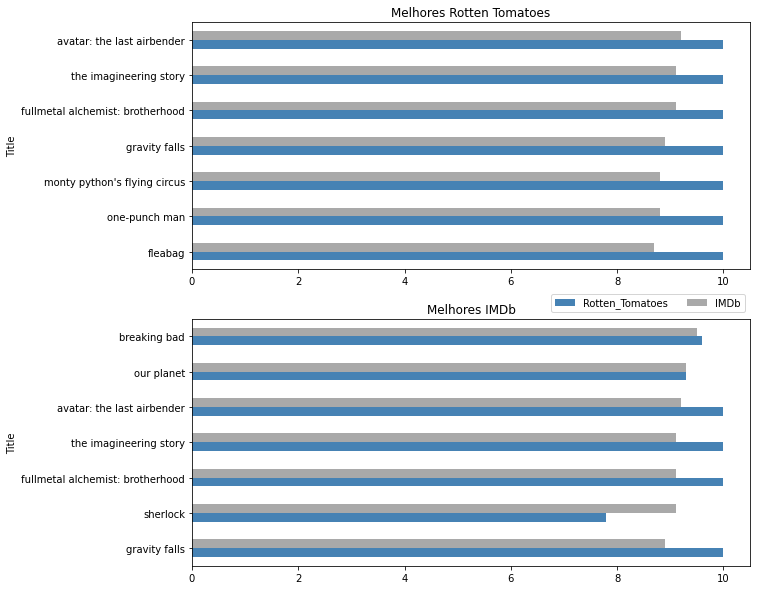

In [5]:
n = 7
colors = ['steelblue', 'darkgray']
RT_IMDb = pd.DataFrame(cshows[['Rotten_Tomatoes', 'IMDb','Streamings','Year']])
RT_IMDb['Rotten_Tomatoes'] = RT_IMDb['Rotten_Tomatoes']/10
RT_IMDb.index = cshows['Title']
best_RT = RT_IMDb.sort_values(by = ['Rotten_Tomatoes','IMDb'],
                              inplace = False,
                              ascending = True)[-n:]
best_IMDb = RT_IMDb.sort_values(by = ['IMDb','Rotten_Tomatoes'],
                                inplace = False,
                                ascending = True)[-n:]
f, ax = plt.subplots(2,1,figsize= (10,10))
best_RT[['Rotten_Tomatoes','IMDb']].plot(kind = 'barh',
                                         figsize = (10,10),
                                         ax = ax[0],
                                         title = 'Melhores Rotten Tomatoes',
                                         color = colors,
                                         legend = False)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol = 2, frameon = True)

best_IMDb[['Rotten_Tomatoes','IMDb']].plot(kind = 'barh',
                                           figsize = (10,10),
                                           ax = ax[1],
                                           title = 'Melhores IMDb',
                                           color = colors)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol = 2, frameon = True)

De modo análogo, podemos ver as notas médias por plataforma de streaming.

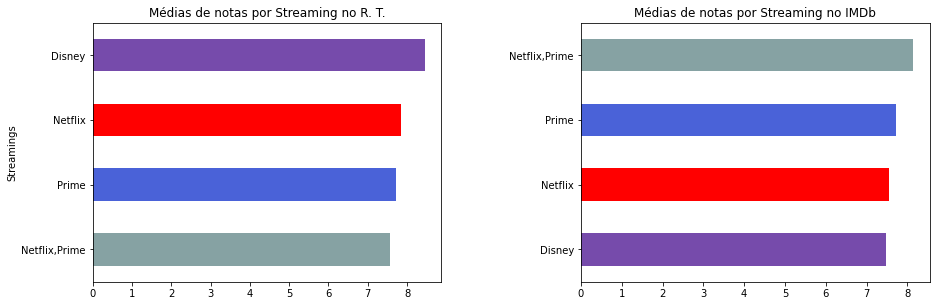

In [6]:
netflix, prime, disney, netflix_prime = '#FF0000', '#4a62d8', '#86a2a3', '#764bab'
Media = RT_IMDb.groupby('Streamings').mean()
Media_RT = Media.sort_values(by = 'Rotten_Tomatoes')
Media_IMDb = Media.sort_values(by = 'IMDb')
f,ax = plt.subplots(1,2,figsize=(15,6))
Media_RT['Rotten_Tomatoes'].plot(ax = ax[0],
                                 kind = 'barh',
                                 color = [disney, prime, netflix, netflix_prime],
                                 title = 'Médias de notas por Streaming no R. T.')
Media_IMDb['IMDb'].plot(ax = ax[1],
                        kind = 'barh',
                        color = [netflix_prime, netflix, prime, disney],
                        title = 'Médias de notas por Streaming no IMDb')
plt.ylabel('')
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.7, 
                    wspace=0.4, 
                    hspace=0.1)

Note que a crítica e o público geral divergem em suas opiniões.

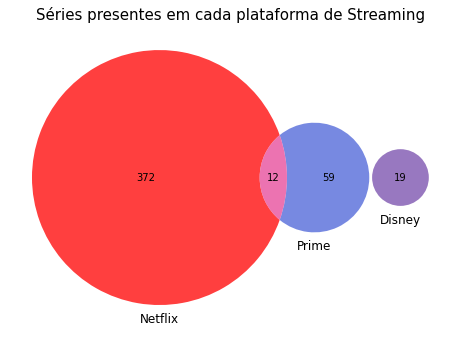

In [7]:
count = dict(RT_IMDb.groupby('Streamings').count()['Year']) # {'Disney': 19, 'Netflix': 372, 'Netflix,Prime': 12, 'Prime': 59}

plt.figure(figsize=(8,8))
venn3(subsets = [372,59,12,19,0,0,0],
      set_labels = ['Netflix','Prime','Disney'],
      set_colors=('#FF0000', '#4a62d8', '#764bab'),
      alpha = 0.75)
plt.title('Séries presentes em cada plataforma de Streaming', fontsize=15)
plt.show()

Abaixo temos uma comparação entre as notas dos dois índices em um gráfico de dispersão.




A correlação entre as duas notas é 0.4780033530603407


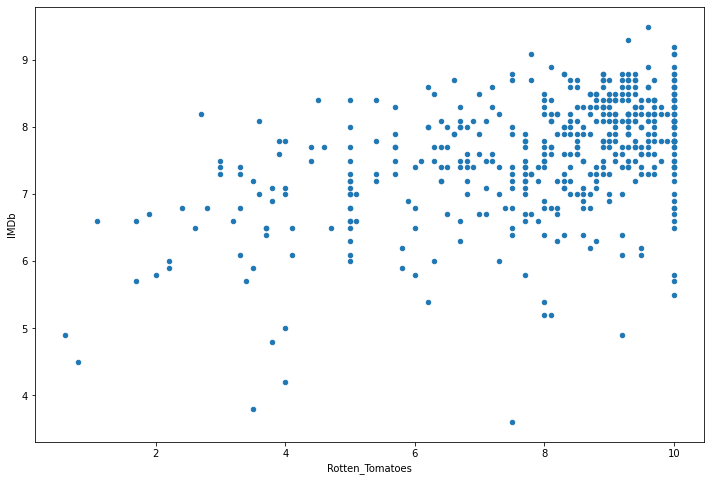

In [8]:
RT_IMDb.plot(kind = 'scatter',
             x = 'Rotten_Tomatoes',
             y = 'IMDb',
             figsize=(12, 8))

print('A correlação entre as duas notas é',
      np.corrcoef(RT_IMDb['Rotten_Tomatoes'],RT_IMDb['IMDb'])[0][1])

Um gráfico mais informativo se dá pelo joinplot dos dados acima.

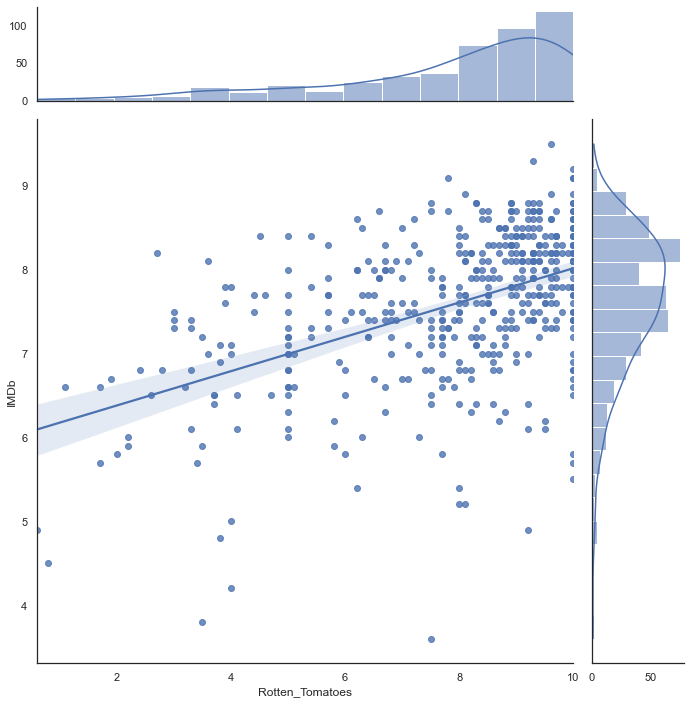

In [9]:
sns.set(style = 'white')

sns.jointplot(kind = 'reg',
              x = RT_IMDb['Rotten_Tomatoes'],
              y = RT_IMDb['IMDb'],
              height = 10,
              marginal_ticks = True)

Mas note que o gráfico acima não mostra se há duplicidade, isso é, não informa se temos duas séries com as mesmas notas, tanto pelo Rotten quanto pelo IMDb. Pensando nisso, podemos fazer a visualização em um heatmap, conforme abaixo.

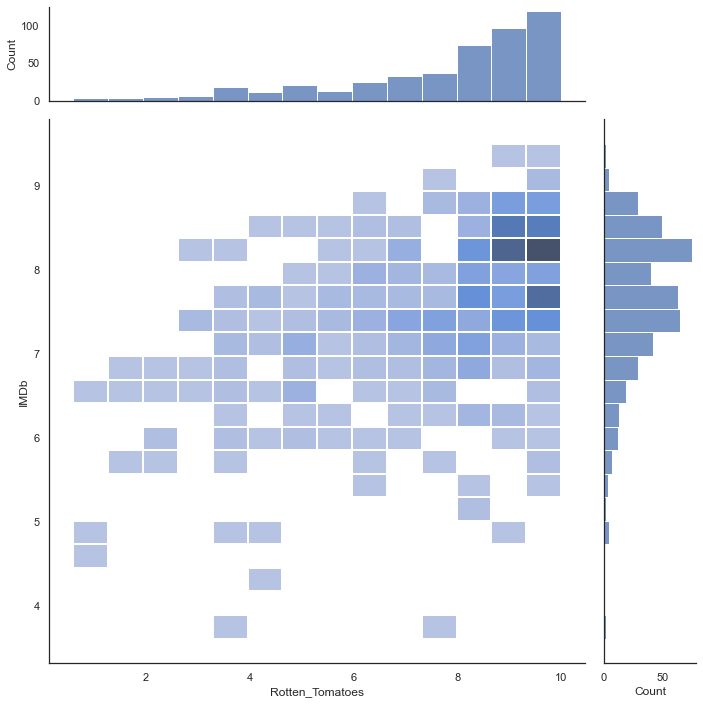

In [10]:
sns.jointplot(kind = 'hist',
              x = RT_IMDb['Rotten_Tomatoes'],
              y = RT_IMDb['IMDb'],
              height = 10,
              edgecolor = 'white',
              marginal_ticks = True)

Conforme calculado, observa-se uma correlação positiva, o que também pode ser observado pelo gráfico, isso é, a nota IMDb tende a ser maior quando a nota do Rotten Tomatoes é maior.

Também podemos os anos com as médias mais altas.

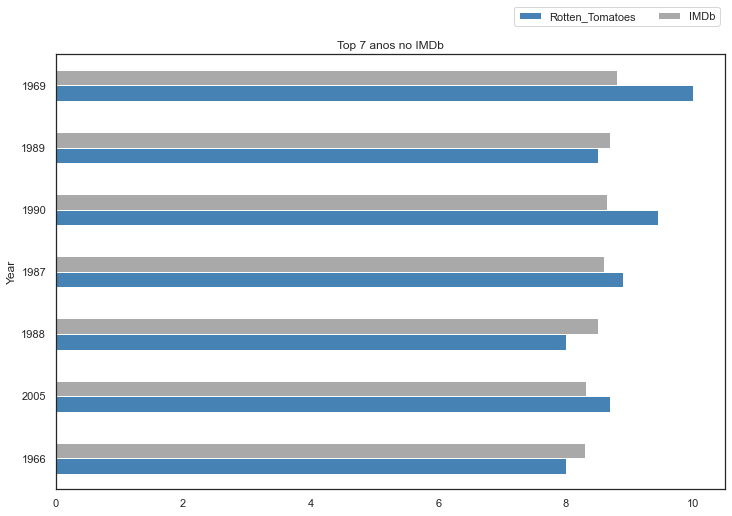

In [11]:
Rank_year = RT_IMDb.groupby('Year').mean()
Rank_year.sort_values(by = ['IMDb', 'Rotten_Tomatoes'],
                      inplace = True,
                      ascending = True)
Rank_year[['Rotten_Tomatoes', 'IMDb']][-7:].plot(kind = 'barh',
                                                 figsize=(12, 8),
                                                 title = 'Top 7 anos no IMDb',
                                                 color = colors)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol = 2, frameon = True)

Também podemos ver a quantidade de séries em um determinado ano.

<AxesSubplot:title={'center':'Quantidade de Séries por ano - todas as plataformas'}, ylabel='Year'>

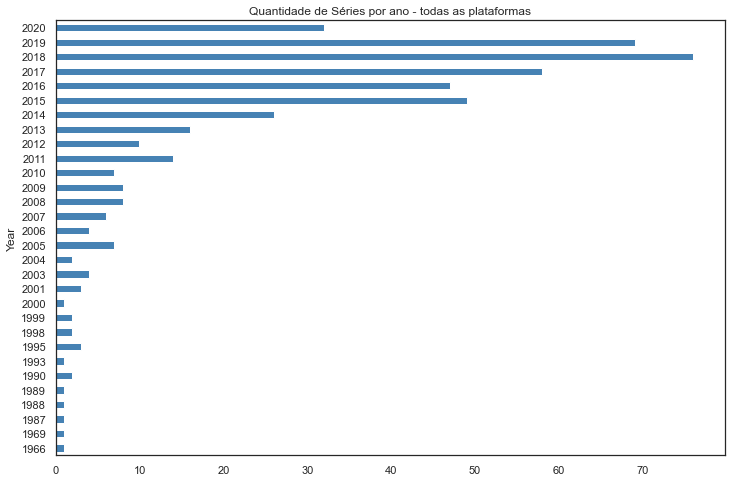

In [12]:
Rank_year = RT_IMDb.groupby('Year').count()
Rank_year[['IMDb']].plot(kind = 'barh',
                          figsize = (12, 8),
                          title = 'Quantidade de Séries por ano - todas as plataformas',
                          color = colors[0],
                          legend = False)

Assim, para deixar mais justa a análise do ano com a melhor nota média entre as séries, seria interessante analisar apenas os anos com mais de 10 séries, isso é, apenas de 2011 em diante. Podemos ver qual a média desses anos no gráfico abaixo.

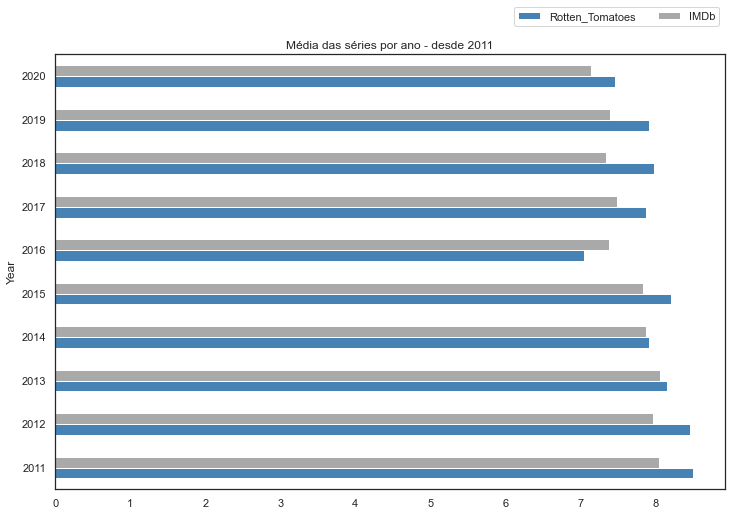

In [13]:
Rank_year = RT_IMDb.groupby('Year').mean()
Rank_year[['Rotten_Tomatoes', 'IMDb']][-10:].plot(kind = 'barh',
                                                 figsize=(12, 8),
                                                 title = 'Média das séries por ano - desde 2011',
                                                 color = colors)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol = 2, frameon = True)

De onde concluímos que 2011 foi o ano com a melhor nota média, tanto no Rotten Tomatoes, quanto no IMDb.

Por fim, podemos analisar como os gêneros se relacionam, isso é, quais gêneros são ligados aos demais.

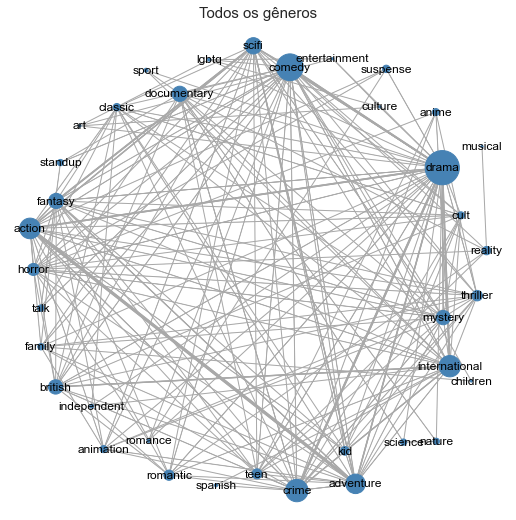

In [14]:
count = dict(cshows.groupby('Genre').count()['Year'])
adjacency_matrix = np.zeros((len(gens), len(gens)))
for gen in gens:
    for comb in count:
        all_gens = comb.split(',')
        if gen in all_gens:
            adjacency_matrix[gens.index(gen), gens.index(gen)] += count[comb]
            for gen_2 in all_gens:
                if gen_2 != gen:
                    adjacency_matrix[gens.index(gen), gens.index(gen_2)] += count[comb]
                    adjacency_matrix[gens.index(gen_2), gens.index(gen)] += count[comb]

G = nx.from_numpy_matrix(adjacency_matrix)
pos = nx.spring_layout(G, k = 1000)
labels = {}
for node in G.nodes():
    labels[node] = gens[node]

weighted_edges = []
width = []
for i in range(len(adjacency_matrix)):
    for j in range(len(adjacency_matrix)):
        weighted_edges.append((i, j))
        width.append(adjacency_matrix[i, j]/50)

plt.figure(figsize=(9,9))
plt.title('Todos os gêneros', fontsize=15)

nx.draw_networkx_labels(G,
                        pos = pos,
                        labels = labels,
                        font_size = 12,
                        font_color = 'black')
nx.draw_networkx_edges(G,
                       pos = pos,
                       edgelist = weighted_edges,
                       width = width,
                       edge_color = 'darkgray')
nx.draw(G,
        pos = pos,
        node_size = [5 * adjacency_matrix[i, i] for i in range(len(gens))],
        edge_color = 'darkgray',
        node_color = 'steelblue')

Note que há uma poluição no grafo acima, portanto, abaixo temos um novo grafo considerando apenas os 10 gêneros que mais aparecem.

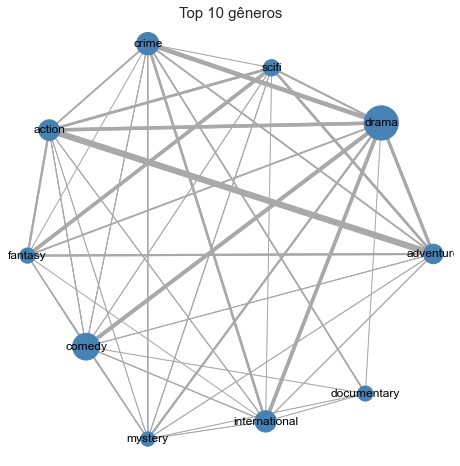

In [15]:
A = [adjacency_matrix[i, i] for i in range(len(gens))]
B = sorted(A, reverse = True)[:10]
aux = []
for qtd in B:
    aux.append(A.index(qtd))

most_common_gens = [gens[i] for i in aux]
most_common_gens[-2] = 'documentary'
adjacency_matrix_2 = np.zeros((len(most_common_gens), len(most_common_gens)))
for gen in most_common_gens:
    for comb in count:
        all_gens = comb.split(',')
        if gen in all_gens:
            adjacency_matrix_2[most_common_gens.index(gen), most_common_gens.index(gen)] += count[comb]
            for gen_2 in all_gens:
                if gen_2 != gen and gen_2 in most_common_gens:
                    adjacency_matrix_2[most_common_gens.index(gen), most_common_gens.index(gen_2)] += count[comb]
                    adjacency_matrix_2[most_common_gens.index(gen_2), most_common_gens.index(gen)] += count[comb]

G = nx.from_numpy_matrix(adjacency_matrix_2)
pos = nx.spring_layout(G, k = 1000)
labels = {}
for node in G.nodes():
    labels[node] = most_common_gens[node]

weighted_edges = []
width = []
for i in range(len(adjacency_matrix_2)):
    for j in range(len(adjacency_matrix_2)):
        weighted_edges.append((i, j))
        width.append(adjacency_matrix_2[i, j]/25)

plt.figure(figsize = (8,8))
plt.title('Top 10 gêneros', fontsize = 15)

nx.draw_networkx_labels(G,
                        pos = pos,
                        labels = labels,
                        font_size = 12,
                        font_color = 'black')
nx.draw_networkx_edges(G,
                       pos = pos,
                       edgelist = weighted_edges,
                       width = width,
                       edge_color = 'darkgray')
nx.draw(G,
        pos = pos,
        node_size = [5 * weight for weight in B],
        edge_color = 'darkgray',
        node_color = 'steelblue')